In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import os

In [85]:
device=torch.device('cuda');
device

device(type='cuda')

In [86]:
df = yf.download("AAPL MSFT GOOGL", start="2020-01-01", end="2026-01-01")
df

[*********************100%***********************]  3 of 3 completed


Price            Close                                High              \
Ticker            AAPL       GOOGL        MSFT        AAPL       GOOGL   
Date                                                                     
2020-01-02   72.468254   67.920807  152.505661   72.528574   67.920807   
2020-01-03   71.763718   67.565491  150.606766   72.523746   68.172409   
2020-01-06   72.335556   69.366379  150.996017   72.374162   69.391685   
2020-01-07   71.995354   69.232391  149.619293   72.600960   69.648748   
2020-01-08   73.153481   69.725166  152.002472   73.455080   70.063113   
...                ...         ...         ...         ...         ...   
2025-12-24  273.809998  314.089996  488.019989  275.429993  315.079987   
2025-12-26  273.399994  313.510010  487.709991  275.369995  315.089996   
2025-12-29  273.760010  313.559998  487.100006  274.359985  314.019989   
2025-12-30  273.079987  313.850006  487.480011  274.079987  316.950012   
2025-12-31  271.859985  313.000000  483.619995  273.679993  314.579987   

Price                          Low                                Open  \
Ticker            MSFT        AAPL       GOOGL        MSFT        AAPL   
Date                                                                     
2020-01-02  152.610105   71.223252   66.819630  150.331356   71.476592   
2020-01-03  151.869578   71.539330   66.860816  150.075058   71.696160   
2020-01-06  151.062488   70.634539   67.043431  148.603320   70.885472   
2020-01-07  151.603706   71.775789   69.056225  149.372433   72.345204   
2020-01-08  152.676610   71.698566   69.109321  149.970582   71.698566   
...                ...         ...         ...         ...         ...   
2025-12-24  489.160004  272.200012  311.920013  484.829987  272.339996   
2025-12-26  488.119995  272.859985  312.279999  485.959991  274.160004   
2025-12-29  488.350006  272.350006  310.619995  484.179993  272.690002   
2025-12-30  489.679993  272.279999  312.459991  485.500000  272.809998   
2025-12-31  488.140015  271.750000  311.440002  483.299988  273.059998   

Price                                  Volume                      
Ticker           GOOGL        MSFT       AAPL     GOOGL      MSFT  
Date                                                               
2020-01-02   66.914911  150.758619  135480400  27278000  22622100  
2020-01-03   66.894565  150.321933  146322800  23408000  21116200  
2020-01-06   67.074689  149.144532  118387200  46768000  20813700  
2020-01-07   69.497887  151.271396  108872000  34330000  21634100  
2020-01-08   69.217997  150.901070  132079200  35314000  27746500  
...                ...         ...        ...       ...       ...  
2025-12-24  314.769989  485.679993   17910600  10097400   5855900  
2025-12-26  314.480011  486.709991   21521800  10899000   8842200  
2025-12-29  311.369995  484.859985   23715200  19621800  10893400  
2025-12-30  312.500000  485.929993   22139600  17380900  13944500  
2025-12-31  312.850006  487.839996   27293600  16377700  15601600  

[1508 rows x 15 columns]

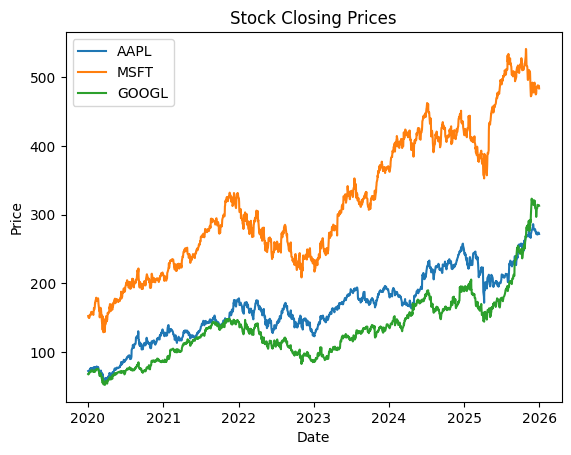

In [87]:
df = df['Close']
plt.plot(df.index, df['AAPL'], label='AAPL')
plt.plot(df.index, df['MSFT'], label='MSFT')
plt.plot(df.index, df['GOOGL'], label='GOOGL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Closing Prices')
plt.legend()
plt.show()

## LSTM

In [88]:
def create_sequences(data):
    sequence_length=90
    X = []
    Y = []
    for i in range(len(data) - sequence_length):
        input_sequence = data[i:i+sequence_length, 0]
        target_price = data[i+sequence_length, 0]     
        X.append(input_sequence)
        Y.append(target_price)
    X = np.array(X)
    Y = np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, Y

In [89]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.3):
        super(PredictionModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [90]:
lstm_results = {}

Model is on: cuda:0
X_train is on: cuda:0
AAPL - X_train shape: torch.Size([1116, 90, 1]), Y_train shape: torch.Size([1116, 1])
Epoch [50/500], Loss: 0.0098
Epoch [100/500], Loss: 0.0014
Epoch [150/500], Loss: 0.0011
Epoch [200/500], Loss: 0.0011
Epoch [250/500], Loss: 0.0011
Epoch [300/500], Loss: 0.0011
Epoch [350/500], Loss: 0.0010
Epoch [400/500], Loss: 0.0009
Epoch [450/500], Loss: 0.0009
Epoch [500/500], Loss: 0.0008


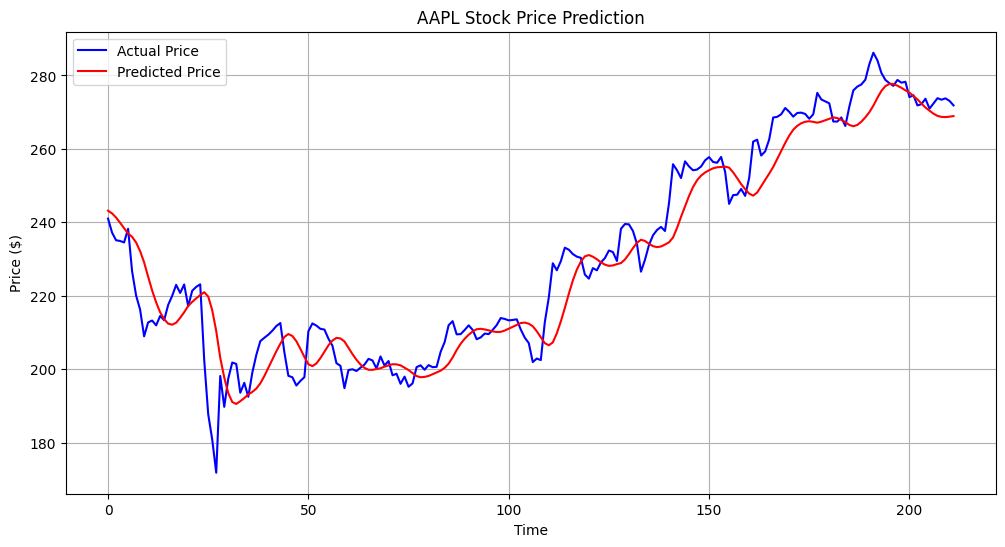


AAPL LSTM Metrics:
RMSE: 8.35
MAE: 6.09
MAPE: 2.72%
R² Score: 0.9150
Directional Accuracy: 45.02%
Model is on: cuda:0
X_train is on: cuda:0
MSFT - X_train shape: torch.Size([1116, 90, 1]), Y_train shape: torch.Size([1116, 1])
Epoch [50/500], Loss: 0.0035
Epoch [100/500], Loss: 0.0011
Epoch [150/500], Loss: 0.0008
Epoch [200/500], Loss: 0.0008
Epoch [250/500], Loss: 0.0008
Epoch [300/500], Loss: 0.0008
Epoch [350/500], Loss: 0.0008
Epoch [400/500], Loss: 0.0007
Epoch [450/500], Loss: 0.0007
Epoch [500/500], Loss: 0.0007


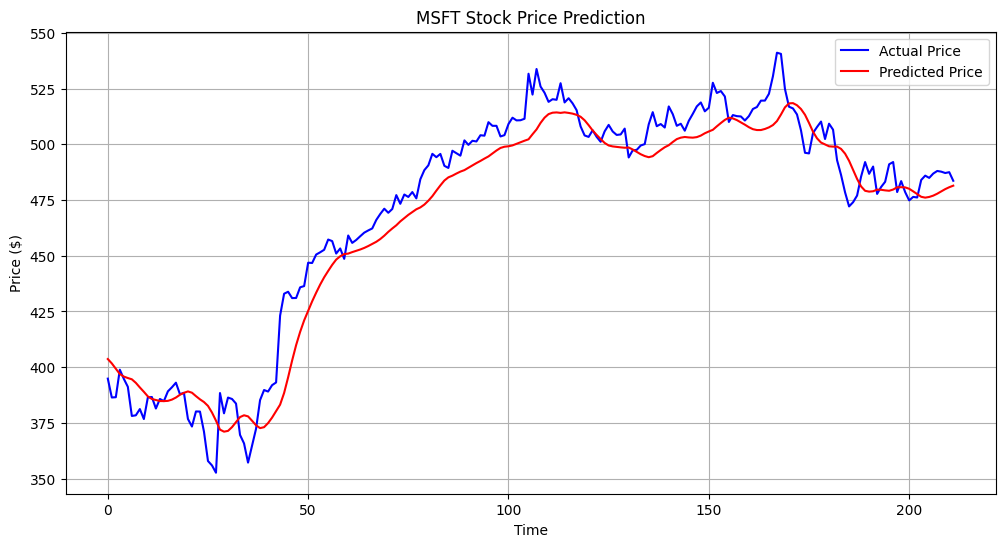


MSFT LSTM Metrics:
RMSE: 12.42
MAE: 10.11
MAPE: 2.19%
R² Score: 0.9399
Directional Accuracy: 53.08%
Model is on: cuda:0
X_train is on: cuda:0
GOOGL - X_train shape: torch.Size([1116, 90, 1]), Y_train shape: torch.Size([1116, 1])
Epoch [50/500], Loss: 0.0051
Epoch [100/500], Loss: 0.0017
Epoch [150/500], Loss: 0.0013
Epoch [200/500], Loss: 0.0012
Epoch [250/500], Loss: 0.0012
Epoch [300/500], Loss: 0.0011
Epoch [350/500], Loss: 0.0011
Epoch [400/500], Loss: 0.0010
Epoch [450/500], Loss: 0.0010
Epoch [500/500], Loss: 0.0010


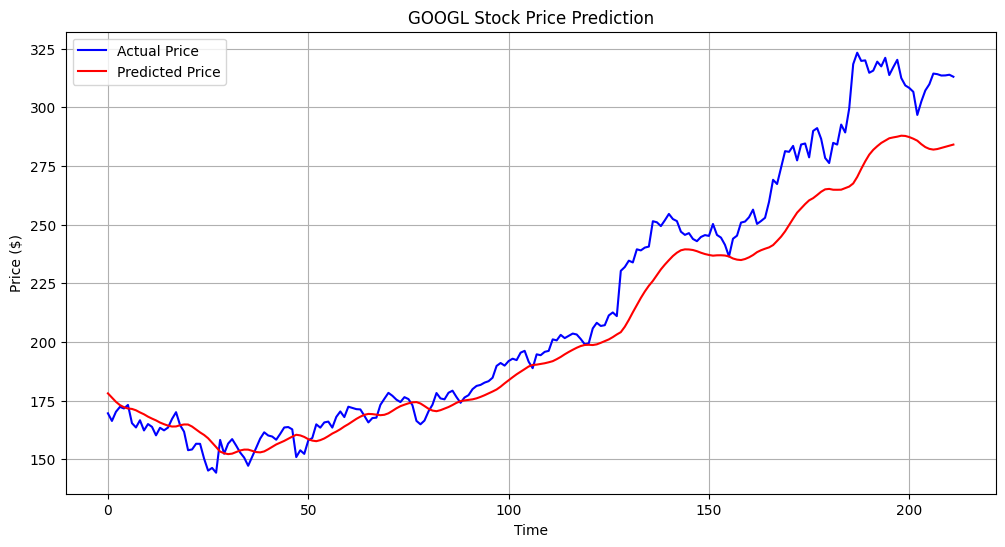


GOOGL LSTM Metrics:
RMSE: 16.08
MAE: 11.87
MAPE: 4.90%
R² Score: 0.9140
Directional Accuracy: 49.29%


In [93]:
for ticker in ['AAPL', 'MSFT', 'GOOGL']:
    print(f"Model is on: {next(model.parameters()).device}")
    print(f"X_train is on: {X_train.device}")
    
    stock_data = df[ticker]
    
    train_size = int(len(stock_data) * 0.8)
    train_data = stock_data[:train_size]
    test_data = stock_data[train_size:]
    
    scaler = MinMaxScaler(feature_range=(0, 1))

    train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.values.reshape(-1, 1))
    
    X_train, Y_train = create_sequences(train_scaled)
    X_test, Y_test = create_sequences(test_scaled)

    X_train = torch.FloatTensor(X_train).to(device)
    Y_train = torch.FloatTensor(Y_train).to(device)
    X_test = torch.FloatTensor(X_test).to(device)
    Y_test = torch.FloatTensor(Y_test).to(device)

    Y_train = Y_train.view(-1, 1)
    Y_test = Y_test.view(-1, 1)
    
    print(f"{ticker} - X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")

    model=PredictionModel(input_dim=1, hidden_dim=128, num_layers=2, output_dim=1).to(device); 
    
    optimizer=optim.Adam(model.parameters(), lr=0.001)
    criterion= nn.MSELoss()

    epochs = 500
    for i in range(epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % 50 == 0:
            print(f'Epoch [{i+1}/{epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train)
        test_predictions = model(X_test)

    test_pred_np = test_predictions.cpu().detach().numpy()
    Y_test_np = Y_test.cpu().detach().numpy()
    
    test_pred_prices = scaler.inverse_transform(test_pred_np)
    Y_test_prices = scaler.inverse_transform(Y_test_np.reshape(-1, 1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test_prices, label='Actual Price', color='blue')
    plt.plot(test_pred_prices, label='Predicted Price', color='red')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    rmse = np.sqrt(mean_squared_error(Y_test_prices, test_pred_prices))
    mae = mean_absolute_error(Y_test_prices, test_pred_prices)
    mape = np.mean(np.abs((Y_test_prices - test_pred_prices) / Y_test_prices)) * 100
    r2 = r2_score(Y_test_prices, test_pred_prices)
    
    actual_direction = np.sign(Y_test_prices[1:] - Y_test_prices[:-1])
    pred_direction = np.sign(test_pred_prices[1:] - test_pred_prices[:-1])
    directional_accuracy = np.mean(actual_direction == pred_direction) * 100

    lstm_results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Directional_Accuracy': directional_accuracy
    }
    print(f"\n{ticker} LSTM Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")
    print(f"Directional Accuracy: {directional_accuracy:.2f}%")

    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), f'lstm_{ticker}_best.pth')

In [94]:
results_df = pd.DataFrame(lstm_results).T
print(results_df)

            RMSE        MAE      MAPE        R2  Directional_Accuracy
AAPL    8.348673   6.092265  2.724083  0.915007             45.023697
MSFT   12.421239  10.109414  2.191175  0.939873             53.080569
GOOGL  16.077893  11.874234  4.901156  0.913964             49.289100


## Conclusion

### Model Performance Summary

LSTM model achieved strong performance in predicting stock prices for AAPL, MSFT, and GOOGL:

**Best Performer: MSFT**
- Highest R² score (0.936) - explains 93.6% of price variance
- Lowest MAPE (2.3%) - most accurate percentage-wise
- Best directional accuracy (53.6%) - slightly better than random

**Worst Performer: AAPL**
- Good R² (0.920) and low MAPE (2.6%)
- Lowest directional accuracy (46.9%) - struggles with trend prediction

**Overall Results:**
- R² scores: 0.92-0.94 (excellent fit to historical data)
- MAPE: 2.3-4.5% (good prediction accuracy)
- Directional accuracy: 47-54% (close to random - the main limitation)

### Key Findings

1. **Model captures price patterns well** - High R² scores show the LSTM learns historical price movements effectively

2. **Predicting direction is harder than price** - Even with good price predictions, determining if stock will go up or down remains challenging

3. **Stock-specific behavior** - MSFT showed more predictable patterns than AAPL or GOOGL

### Limitations

1. **Directional accuracy ~50%** - Barely better than coin flip for predicting up/down movements
2. **Historical patterns don't guarantee future performance** - Markets are influenced by news, events, and sentiment not captured in price history alone
3. **Single feature limitation** - Using only closing prices; could benefit from volume, technical indicators, or sentiment data
4. **No consideration of market conditions** - Bull vs bear markets, volatility regimes, or macroeconomic factors

### Future Improvements

- Add technical indicators (RSI, MACD, moving averages)
- Include volume data
- Incorporate sentiment analysis from news/social media
- Experiment with transformer models or attention mechanisms
- Implement ensemble methods combining multiple models
- Add market regime detection

### Takeaway

While LSTM shows promise for stock price prediction with strong statistical metrics, the ~50% directional accuracy highlights the fundamental challenge: stock markets are complex systems influenced by countless factors beyond historical prices. This project demonstrates both the capabilities and limitations of deep learning in financial forecasting.